In [0]:
import gc
import time
import datetime
import numpy as np
import pandas as pd
from scipy import sparse
# import plot librairies
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

# Read data

In [0]:
path = './data/'
label = 'click'

In [6]:
train = pd.read_csv(path + 'train.txt', sep='\t', encoding='utf-8')
train = train.drop_duplicates().reset_index()
test = pd.read_csv(path + 'test.txt', sep='\t', encoding='utf-8')
res = test[['instance_id']]
test[label] = -1
data = pd.concat([train, test], axis=0, ignore_index=True)

del data['instance_id']
del train['index']
del train
del test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [7]:
data.head(5)

,adid,advert_id,advert_industry_inner,advert_name,app_cate_id,app_id,app_paid,campaign_id,carrier,city,click,creative_has_deeplink,creative_height,creative_id,creative_is_download,creative_is_js,creative_is_jump,creative_is_voicead,creative_tp_dnf,creative_type,creative_width,devtype,f_channel,index,inner_slot_id,make,model,nnt,orderid,os,os_name,osv,province,time,user_tags
0,1560128,230000063,102400_102401,B4734117F35EE97F,107.0,2089229.0,False,1000023,1,137103102105100,0,False,720,2338420,False,False,True,False,8390267734059046014,8,1280,2,NaN,0.0,xf_275C061483984E075832A4373BDDF27B,HUAWEI,HUAWEI-CAZ-AL10,1,3010798,2,android,7.0.0,137103102100100,2190219034,NaN
1,1488859,230000063,102400_102401,B4734117F35EE97F,108.0,2070079.0,False,1000023,3,137105101100100,0,False,640,2310417,False,False,True,False,8390208550469153745,8,960,2,NaN,1.0,xf_D84DAB691E2E08C5B80D2FF5135F886E,Xiaomi,Redmi Note 4,1,2311397,2,android,6.0,137105101100100,2190221070,"2100191,2100078,3001825,,3001781,3001791,30017..."
2,1537089,230000065,101700_101704,E257895F74792E81,100.0,2089397.0,False,1000021,3,137103104111100,0,False,640,2337017,False,False,True,False,8390430283595430291,8,960,2,NaN,2.0,xf_7F9FF3BEA11FE5B3AE6332EFBBD59496,OPPO,OPPO+R11s,1,3008491,2,android,7.1.1,137103104100100,2190219793,NaN
3,1577884,230001710,101900_101902,0A421D7B11EABFC5,100.0,2071234.0,False,1003544,0,137103102113100,0,False,720,2342152,False,False,True,False,8390229093704413749,3,1280,2,iqy_2,3.0,iqy_1000000000381-1-15-15,NaN,OPPO A57,1,3011304,2,android,6.0.1,137103102100100,2190221704,"2100098,gd_2100000,3001791,3001795,3002193,300..."
4,1432367,230000063,102400_102401,B4734117F35EE97F,103.0,1030051.0,False,1000023,1,137103102109100,0,False,640,2305409,False,False,True,False,8390208550469153745,8,960,2,NaN,4.0,xf_6C4DCB36DBE7EB12CE55EDF319FF8D93,Apple,iPhone 7,3,2304491,1,ios,11.1.1,137103102100100,2190220024,NaN


In [8]:
data.info()
# data['time'].head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041674 entries, 0 to 1041673
Data columns (total 35 columns):
adid                     1041674 non-null int64
advert_id                1041674 non-null int64
advert_industry_inner    1041674 non-null object
advert_name              1041674 non-null object
app_cate_id              1039376 non-null float64
app_id                   1039376 non-null float64
app_paid                 1041674 non-null bool
campaign_id              1041674 non-null int64
carrier                  1041674 non-null int64
city                     1041674 non-null int64
click                    1041674 non-null int64
creative_has_deeplink    1041674 non-null bool
creative_height          1041674 non-null int64
creative_id              1041674 non-null int64
creative_is_download     1041674 non-null bool
creative_is_js           1041674 non-null bool
creative_is_jump         1041674 non-null bool
creative_is_voicead      1041674 non-null bool
creative_tp_dnf        

- instance_id: id pour un exemple
- click: si cliquer pub

### info pour pub
- adid: pub id
- advert_id: id pour un annonceur d'une publicité
- orderid: id pour un command
- advert_industry_inner: le secteur pour l'annonceur
- advert_name: nom pour l'annonceur
- campaign_id: id pour une compagne
- creative_id: id pour une créativité
- creative_type: type de l'idée
- creative_tp_dnf: id pour un type de créativité
- creative_has_deeplink: boolean s'il y a deeplink
- creative_is_jump: boolean si ça saute
- creative_is_download: boolean si ça télécharger
- creative_is_js: si ça js
- creative_is_voicead: s'il y a pub vocale
- creative_width: largeur pour un pub
- creative_height: hauteur 

### info pour media
- app_cate_id: classification de apps
- f_channel: channel de télé
- app_id: id pour média
- inner_slot_id: pub pour média
- app_paid: boolean si c'est payant pour une app

### info pour utilisateur
- user_tags: Informations sur l'étiquette de utilisateur, sep=','

### info pour contexte
- city: cité
- carrier: opérateur
- time: timestamp
- province: province
- nnt: genre de connection de réseau
- devtype: type d'appareil
- os_name: nom de os
- osv: version de os
- os: os
- make: marque (Apple)
- model: modèle (iphone)


# Statistiques descriptives et visualisation

- Analyser une partie des données et obtenir la distribution du taux de conversion de chaque caractéristique de catégorie pour juger de l'effet de caractéristique
- L’exposition au tracé et les taux de clic changent à différents moments

In [0]:
sns.set(style='whitegrid', palette='muted', color_codes=True)
sns.set(rc={'figure.figsize': (8, 6)})
sns.set(font_scale=1)

In [0]:
def process_time():
    day = []
    hour = []
    for time_stamp in data['time'].values:
        t = datetime.datetime.fromtimestamp(time_stamp+3600*24*5)
        day.append(t.day)
        hour.append(t.hour)
    data['day'] = day
    data['hour'] = hour
    data['hour_sequence'] =  (data['hour']//6).astype(int)


In [0]:
# day, hour = get_time_list(data['time'].values)
# data['day'] = day
# data['hour'] = hour
# data['hour_sequence'] =  (data['hour']//6).astype(int)
# del data['time']
process_time()

In [12]:
data.head(5)

,adid,advert_id,advert_industry_inner,advert_name,app_cate_id,app_id,app_paid,campaign_id,carrier,city,click,creative_has_deeplink,creative_height,creative_id,creative_is_download,creative_is_js,creative_is_jump,creative_is_voicead,creative_tp_dnf,creative_type,creative_width,devtype,f_channel,index,inner_slot_id,make,model,nnt,orderid,os,os_name,osv,province,time,user_tags,day,hour,hour_sequence
0,1560128,230000063,102400_102401,B4734117F35EE97F,107.0,2089229.0,False,1000023,1,137103102105100,0,False,720,2338420,False,False,True,False,8390267734059046014,8,1280,2,NaN,0.0,xf_275C061483984E075832A4373BDDF27B,HUAWEI,HUAWEI-CAZ-AL10,1,3010798,2,android,7.0.0,137103102100100,2190219034,NaN,2,18,3
1,1488859,230000063,102400_102401,B4734117F35EE97F,108.0,2070079.0,False,1000023,3,137105101100100,0,False,640,2310417,False,False,True,False,8390208550469153745,8,960,2,NaN,1.0,xf_D84DAB691E2E08C5B80D2FF5135F886E,Xiaomi,Redmi Note 4,1,2311397,2,android,6.0,137105101100100,2190221070,"2100191,2100078,3001825,,3001781,3001791,30017...",2,18,3
2,1537089,230000065,101700_101704,E257895F74792E81,100.0,2089397.0,False,1000021,3,137103104111100,0,False,640,2337017,False,False,True,False,8390430283595430291,8,960,2,NaN,2.0,xf_7F9FF3BEA11FE5B3AE6332EFBBD59496,OPPO,OPPO+R11s,1,3008491,2,android,7.1.1,137103104100100,2190219793,NaN,2,18,3
3,1577884,230001710,101900_101902,0A421D7B11EABFC5,100.0,2071234.0,False,1003544,0,137103102113100,0,False,720,2342152,False,False,True,False,8390229093704413749,3,1280,2,iqy_2,3.0,iqy_1000000000381-1-15-15,NaN,OPPO A57,1,3011304,2,android,6.0.1,137103102100100,2190221704,"2100098,gd_2100000,3001791,3001795,3002193,300...",2,18,3
4,1432367,230000063,102400_102401,B4734117F35EE97F,103.0,1030051.0,False,1000023,1,137103102109100,0,False,640,2305409,False,False,True,False,8390208550469153745,8,960,2,NaN,4.0,xf_6C4DCB36DBE7EB12CE55EDF319FF8D93,Apple,iPhone 7,3,2304491,1,ios,11.1.1,137103102100100,2190220024,NaN,2,18,3


- Les taux d'exposition et de clic changent à des moments différents

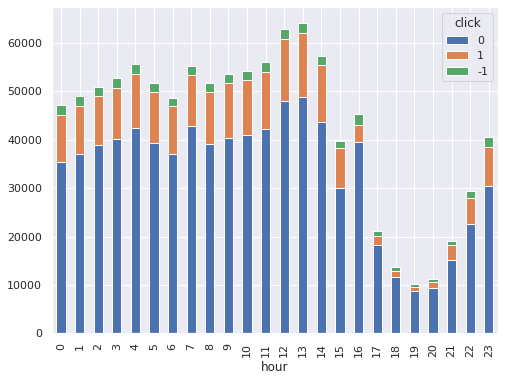

In [25]:
hour_df = data.groupby(['hour', 'click'])['hour'].count().unstack('click').fillna(0)
hour_df[[0, 1, -1]].plot(kind='bar', stacked=True)
plt.show()

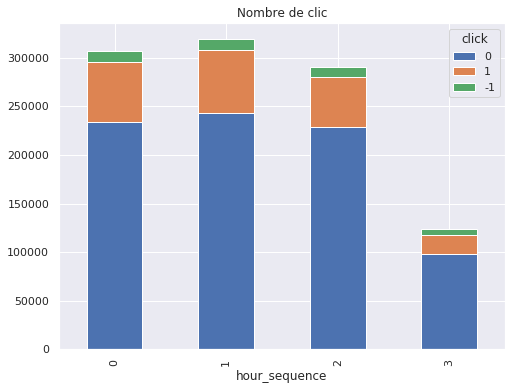

In [24]:
hour_df = data.groupby(['hour_sequence', 'click'])['hour_sequence'].count().unstack('click').fillna(0)
hour_df[[0, 1, -1]].plot(kind='bar', stacked=True, title='Nombre de clic')
plt.show()

- Taux de l'échantillion positif et celui négative

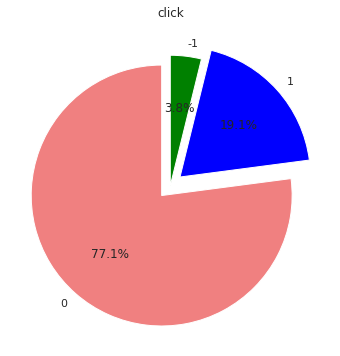

In [27]:
labels = [0, 1, -1]
sizes = data.click.value_counts().values
explode=[0.1, 0.1, 0]
colors = ['lightcoral', 'blue', 'green']
patches, texts,autotexts= plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct="%1.1f%%", startangle=90)
plt.title("click")
plt.show()

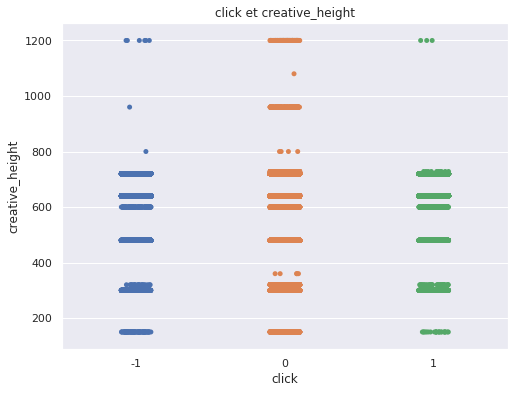

In [18]:
sns.stripplot(data["click"],data["creative_height"],jitter=True)
plt.title("click et creative_height")
plt.show()

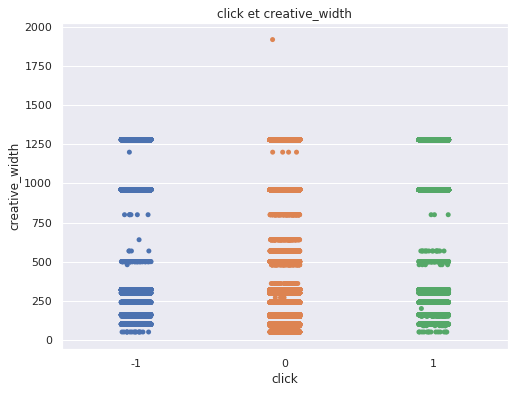

In [26]:
sns.stripplot(data["click"],data["creative_width"],jitter=True)
plt.title("click et creative_width")
plt.show()

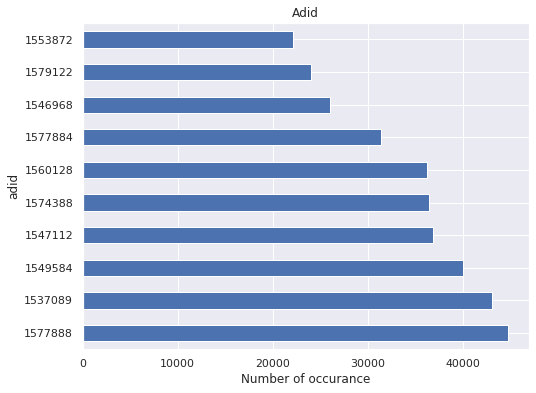

In [28]:
ax = data['adid'].value_counts()[:10].plot(kind='barh', stacked=False, title='Adid')
ax.set_ylabel('adid')
ax.set_xlabel('Number of occurance')
plt.show()

- traiter "make", on crée une nouvelle varaibel 'new_make', enfin ,on doit supprimer la variabel 'make'

In [0]:
def process_make():
    result = []
    for var in data['make'].values:
        var = str(var)
        if ',' in var:
            result.append(var.split(',')[0].lower())
        elif ' ' in var:
            result.append(var.split(' ')[0].lower())
        elif '-' in var:
            result.append(var.split('-')[0].lower())
        else:
            result.append(var.lower())
    
    for i in range(len(result)):
        if 'iphone' in result[i]:
            result[i] = 'apple'
        elif 'redmi' in result[i]:
            result[i] = 'xiaomi'
        elif result[i]=='mi':
            result[i] = 'xiaomi'
        elif result[i]=='meitu':
            result[i] = 'meizu'
        elif result[i]=='nan':
            result[i] = np.nan
        elif result[i]=='honor':
            result[i] = 'huawei'
        elif result[i]=='le' or result[i]=='letv' or result[i]=='lemobile' or result[i]=='lephone' or result[i]=='blephone':
            result[i] = 'leshi'
    try:
        data['new_make'] = result
    except Exception as error:
        print(error)

In [30]:
process_make()
data['new_make'].head(10)

0    huawei
1    xiaomi
2      oppo
3       NaN
4     apple
5    xiaomi
6     apple
7    huawei
8       NaN
9      vivo
Name: new_make, dtype: object

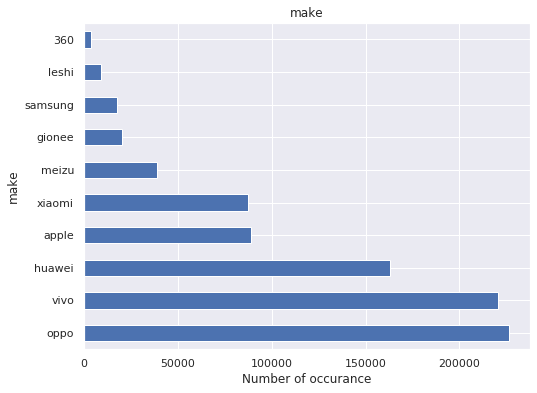

In [31]:
ax = data['new_make'].value_counts()[:10].plot(kind='barh', stacked=False, title='make')
ax.set_ylabel('make')
ax.set_xlabel('Number of occurance')
plt.show()

- process advert_industry_inner et la varibale 'inner_slot_id'

In [32]:
data['advert_industry_inner']
# data['inner_slot_id'].head(10)

0          102400_102401
1          102400_102401
2          101700_101704
3          101900_101902
4          102400_102401
               ...      
1041669    102400_102401
1041670        16_100509
1041671    101700_101704
1041672    102400_102401
1041673        16_100509
Name: advert_industry_inner, Length: 1041674, dtype: object

In [0]:
def process_advert_industry_inner():
    result1 = []
    result2 = []
    for var in data['advert_industry_inner'].values:
        result1.append(var.split('_')[0])
        result2.append(var.split('_')[1])
    data['advert_industry_inner1'] = result1
    data['advert_industry_inner2'] = result2

def process_inner_slot_id():
    result = []
    for var in data['inner_slot_id'].values:
        result.append(var.split('_')[0])

    data['inner_slot_id1'] = result

process_advert_industry_inner()
process_inner_slot_id()

In [34]:
data[['advert_industry_inner', 'advert_industry_inner1', 'advert_industry_inner2', 'inner_slot_id', 'inner_slot_id1']].head(5)

,advert_industry_inner,advert_industry_inner1,advert_industry_inner2,inner_slot_id,inner_slot_id1
0,102400_102401,102400,102401,xf_275C061483984E075832A4373BDDF27B,xf
1,102400_102401,102400,102401,xf_D84DAB691E2E08C5B80D2FF5135F886E,xf
2,101700_101704,101700,101704,xf_7F9FF3BEA11FE5B3AE6332EFBBD59496,xf
3,101900_101902,101900,101902,iqy_1000000000381-1-15-15,iqy
4,102400_102401,102400,102401,xf_6C4DCB36DBE7EB12CE55EDF319FF8D93,xf


In [0]:
def process_model():
    result = []
    for var in data['model'].values:
        var = str(var)
        if ',' in var:
            result.append(var.replace(',',' '))
        elif '+' in var:
            result.append(var.replace('+',' '))
        elif '-' in var:
            result.append(var.replace('-',' '))
        elif 'nan'==var:
            result.append(np.nan)
        else:
            result.append(var)
    data['new_model'] = result

process_model()

In [36]:
data[['model', 'new_model']]
data.head(5)

,adid,advert_id,advert_industry_inner,advert_name,app_cate_id,app_id,app_paid,campaign_id,carrier,city,click,creative_has_deeplink,creative_height,creative_id,creative_is_download,creative_is_js,creative_is_jump,creative_is_voicead,creative_tp_dnf,creative_type,creative_width,devtype,f_channel,index,inner_slot_id,make,model,nnt,orderid,os,os_name,osv,province,time,user_tags,day,hour,hour_sequence,new_make,advert_industry_inner1,advert_industry_inner2,inner_slot_id1,new_model
0,1560128,230000063,102400_102401,B4734117F35EE97F,107.0,2089229.0,False,1000023,1,137103102105100,0,False,720,2338420,False,False,True,False,8390267734059046014,8,1280,2,NaN,0.0,xf_275C061483984E075832A4373BDDF27B,HUAWEI,HUAWEI-CAZ-AL10,1,3010798,2,android,7.0.0,137103102100100,2190219034,NaN,2,18,3,huawei,102400,102401,xf,HUAWEI CAZ AL10
1,1488859,230000063,102400_102401,B4734117F35EE97F,108.0,2070079.0,False,1000023,3,137105101100100,0,False,640,2310417,False,False,True,False,8390208550469153745,8,960,2,NaN,1.0,xf_D84DAB691E2E08C5B80D2FF5135F886E,Xiaomi,Redmi Note 4,1,2311397,2,android,6.0,137105101100100,2190221070,"2100191,2100078,3001825,,3001781,3001791,30017...",2,18,3,xiaomi,102400,102401,xf,Redmi Note 4
2,1537089,230000065,101700_101704,E257895F74792E81,100.0,2089397.0,False,1000021,3,137103104111100,0,False,640,2337017,False,False,True,False,8390430283595430291,8,960,2,NaN,2.0,xf_7F9FF3BEA11FE5B3AE6332EFBBD59496,OPPO,OPPO+R11s,1,3008491,2,android,7.1.1,137103104100100,2190219793,NaN,2,18,3,oppo,101700,101704,xf,OPPO R11s
3,1577884,230001710,101900_101902,0A421D7B11EABFC5,100.0,2071234.0,False,1003544,0,137103102113100,0,False,720,2342152,False,False,True,False,8390229093704413749,3,1280,2,iqy_2,3.0,iqy_1000000000381-1-15-15,NaN,OPPO A57,1,3011304,2,android,6.0.1,137103102100100,2190221704,"2100098,gd_2100000,3001791,3001795,3002193,300...",2,18,3,NaN,101900,101902,iqy,OPPO A57
4,1432367,230000063,102400_102401,B4734117F35EE97F,103.0,1030051.0,False,1000023,1,137103102109100,0,False,640,2305409,False,False,True,False,8390208550469153745,8,960,2,NaN,4.0,xf_6C4DCB36DBE7EB12CE55EDF319FF8D93,Apple,iPhone 7,3,2304491,1,ios,11.1.1,137103102100100,2190220024,NaN,2,18,3,apple,102400,102401,xf,iPhone 7


- traiter la variable 'os' et 'osv'

In [0]:
def process_os_osv():
    data['os'].replace(2, 0, inplace=True)
    result = []
    for var in data['osv'].values:
        var = str(var)
        var = var.replace('iOS', '')
        var = var.replace('android', '')
        var = var.replace(' ', '')
        var = var.replace('iPhoneOS', '')
        var = var.replace('_', '.')
        var = var.replace('Android5.1', '.')
        try:
            int(var)
            result.append(np.nan)
        except:
            sp = ['nan', '11.39999961853027', '10.30000019073486', 'unknown', '11.30000019073486']
            if var in sp:
                result.append(np.nan)
            elif var == '3.0.4-RS-20160720.1914':
                result.append('3.0.4')
            else:
                result.append(var)

    temp = pd.Series(result).value_counts()
    temp = temp[temp <= 2].index.tolist()
    for i in range(len(result)):
        if result[i] in temp:
            result[i] = np.nan
    data['osv'] = result
    result1 = []
    result2 = []
    result3 = []
    for var in data['osv'].values:
        var = str(var).split('.')
        if len(var) < 3:
            var.extend(['0', '0', '0'])
        result1.append(var[0])
        result2.append(var[1])
        result3.append(var[2])
    data['osv1'] = result1
    data['osv2'] = result2
    data['osv3'] = result3

In [0]:
process_os_osv()

In [39]:
data.head(5)

,adid,advert_id,advert_industry_inner,advert_name,app_cate_id,app_id,app_paid,campaign_id,carrier,city,click,creative_has_deeplink,creative_height,creative_id,creative_is_download,creative_is_js,creative_is_jump,creative_is_voicead,creative_tp_dnf,creative_type,creative_width,devtype,f_channel,index,inner_slot_id,make,model,nnt,orderid,os,os_name,osv,province,time,user_tags,day,hour,hour_sequence,new_make,advert_industry_inner1,advert_industry_inner2,inner_slot_id1,new_model,osv1,osv2,osv3
0,1560128,230000063,102400_102401,B4734117F35EE97F,107.0,2089229.0,False,1000023,1,137103102105100,0,False,720,2338420,False,False,True,False,8390267734059046014,8,1280,2,NaN,0.0,xf_275C061483984E075832A4373BDDF27B,HUAWEI,HUAWEI-CAZ-AL10,1,3010798,0,android,7.0.0,137103102100100,2190219034,NaN,2,18,3,huawei,102400,102401,xf,HUAWEI CAZ AL10,7,0,0
1,1488859,230000063,102400_102401,B4734117F35EE97F,108.0,2070079.0,False,1000023,3,137105101100100,0,False,640,2310417,False,False,True,False,8390208550469153745,8,960,2,NaN,1.0,xf_D84DAB691E2E08C5B80D2FF5135F886E,Xiaomi,Redmi Note 4,1,2311397,0,android,6.0,137105101100100,2190221070,"2100191,2100078,3001825,,3001781,3001791,30017...",2,18,3,xiaomi,102400,102401,xf,Redmi Note 4,6,0,0
2,1537089,230000065,101700_101704,E257895F74792E81,100.0,2089397.0,False,1000021,3,137103104111100,0,False,640,2337017,False,False,True,False,8390430283595430291,8,960,2,NaN,2.0,xf_7F9FF3BEA11FE5B3AE6332EFBBD59496,OPPO,OPPO+R11s,1,3008491,0,android,7.1.1,137103104100100,2190219793,NaN,2,18,3,oppo,101700,101704,xf,OPPO R11s,7,1,1
3,1577884,230001710,101900_101902,0A421D7B11EABFC5,100.0,2071234.0,False,1003544,0,137103102113100,0,False,720,2342152,False,False,True,False,8390229093704413749,3,1280,2,iqy_2,3.0,iqy_1000000000381-1-15-15,NaN,OPPO A57,1,3011304,0,android,6.0.1,137103102100100,2190221704,"2100098,gd_2100000,3001791,3001795,3002193,300...",2,18,3,NaN,101900,101902,iqy,OPPO A57,6,0,1
4,1432367,230000063,102400_102401,B4734117F35EE97F,103.0,1030051.0,False,1000023,1,137103102109100,0,False,640,2305409,False,False,True,False,8390208550469153745,8,960,2,NaN,4.0,xf_6C4DCB36DBE7EB12CE55EDF319FF8D93,Apple,iPhone 7,3,2304491,1,ios,11.1.1,137103102100100,2190220024,NaN,2,18,3,apple,102400,102401,xf,iPhone 7,11,1,1


- traiter les variables boolean

In [0]:
def process_bool_vars():
    bool_features = ['app_paid', 'creative_has_deeplink', 'creative_is_download', 'creative_is_js', 'creative_is_jump', 'creative_is_voicead']
    for bool_feature in bool_features:
        data[bool_feature] = data[bool_feature].astype(int)


In [0]:
process_bool_vars()

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041674 entries, 0 to 1041673
Data columns (total 46 columns):
adid                      1041674 non-null int64
advert_id                 1041674 non-null int64
advert_industry_inner     1041674 non-null object
advert_name               1041674 non-null object
app_cate_id               1039376 non-null float64
app_id                    1039376 non-null float64
app_paid                  1041674 non-null int64
campaign_id               1041674 non-null int64
carrier                   1041674 non-null int64
city                      1041674 non-null int64
click                     1041674 non-null int64
creative_has_deeplink     1041674 non-null int64
creative_height           1041674 non-null int64
creative_id               1041674 non-null int64
creative_is_download      1041674 non-null int64
creative_is_js            1041674 non-null int64
creative_is_jump          1041674 non-null int64
creative_is_voicead       1041674 non-null int64

In [43]:
data.head(5)

,adid,advert_id,advert_industry_inner,advert_name,app_cate_id,app_id,app_paid,campaign_id,carrier,city,click,creative_has_deeplink,creative_height,creative_id,creative_is_download,creative_is_js,creative_is_jump,creative_is_voicead,creative_tp_dnf,creative_type,creative_width,devtype,f_channel,index,inner_slot_id,make,model,nnt,orderid,os,os_name,osv,province,time,user_tags,day,hour,hour_sequence,new_make,advert_industry_inner1,advert_industry_inner2,inner_slot_id1,new_model,osv1,osv2,osv3
0,1560128,230000063,102400_102401,B4734117F35EE97F,107.0,2089229.0,0,1000023,1,137103102105100,0,0,720,2338420,0,0,1,0,8390267734059046014,8,1280,2,NaN,0.0,xf_275C061483984E075832A4373BDDF27B,HUAWEI,HUAWEI-CAZ-AL10,1,3010798,0,android,7.0.0,137103102100100,2190219034,NaN,2,18,3,huawei,102400,102401,xf,HUAWEI CAZ AL10,7,0,0
1,1488859,230000063,102400_102401,B4734117F35EE97F,108.0,2070079.0,0,1000023,3,137105101100100,0,0,640,2310417,0,0,1,0,8390208550469153745,8,960,2,NaN,1.0,xf_D84DAB691E2E08C5B80D2FF5135F886E,Xiaomi,Redmi Note 4,1,2311397,0,android,6.0,137105101100100,2190221070,"2100191,2100078,3001825,,3001781,3001791,30017...",2,18,3,xiaomi,102400,102401,xf,Redmi Note 4,6,0,0
2,1537089,230000065,101700_101704,E257895F74792E81,100.0,2089397.0,0,1000021,3,137103104111100,0,0,640,2337017,0,0,1,0,8390430283595430291,8,960,2,NaN,2.0,xf_7F9FF3BEA11FE5B3AE6332EFBBD59496,OPPO,OPPO+R11s,1,3008491,0,android,7.1.1,137103104100100,2190219793,NaN,2,18,3,oppo,101700,101704,xf,OPPO R11s,7,1,1
3,1577884,230001710,101900_101902,0A421D7B11EABFC5,100.0,2071234.0,0,1003544,0,137103102113100,0,0,720,2342152,0,0,1,0,8390229093704413749,3,1280,2,iqy_2,3.0,iqy_1000000000381-1-15-15,NaN,OPPO A57,1,3011304,0,android,6.0.1,137103102100100,2190221704,"2100098,gd_2100000,3001791,3001795,3002193,300...",2,18,3,NaN,101900,101902,iqy,OPPO A57,6,0,1
4,1432367,230000063,102400_102401,B4734117F35EE97F,103.0,1030051.0,0,1000023,1,137103102109100,0,0,640,2305409,0,0,1,0,8390208550469153745,8,960,2,NaN,4.0,xf_6C4DCB36DBE7EB12CE55EDF319FF8D93,Apple,iPhone 7,3,2304491,1,ios,11.1.1,137103102100100,2190220024,NaN,2,18,3,apple,102400,102401,xf,iPhone 7,11,1,1


In [0]:
def process_user_tags():
    se = pd.Series(data['user_tags'].drop_duplicates().values)
    data['user_id'] = data['user_tags'].map(pd.Series(se.index,index=se.values))
    data['user_tags'].fillna(value='-1',inplace=True)

    result = []
    for var in data['user_tags'].values:
        var = var.replace(',', ' ')
        result.append(var)
    data['user_tags'] = result


In [0]:
process_user_tags()

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041674 entries, 0 to 1041673
Data columns (total 47 columns):
adid                      1041674 non-null int64
advert_id                 1041674 non-null int64
advert_industry_inner     1041674 non-null object
advert_name               1041674 non-null object
app_cate_id               1039376 non-null float64
app_id                    1039376 non-null float64
app_paid                  1041674 non-null int64
campaign_id               1041674 non-null int64
carrier                   1041674 non-null int64
city                      1041674 non-null int64
click                     1041674 non-null int64
creative_has_deeplink     1041674 non-null int64
creative_height           1041674 non-null int64
creative_id               1041674 non-null int64
creative_is_download      1041674 non-null int64
creative_is_js            1041674 non-null int64
creative_is_jump          1041674 non-null int64
creative_is_voicead       1041674 non-null int64

- traiter las variabels ayant les valeurs absentes et encoder ces variables

In [47]:
features = ['city', 'province','carrier', 'devtype', 'make', 'nnt','osv',
            'model','new_make','new_model', 'os', 'os_name', 'user_id', 
            'inner_slot_id1','adid', 'advert_id', 'orderid', 
            'campaign_id','advert_industry_inner','creative_id', 
            'creative_tp_dnf', 'app_cate_id', 'f_channel', 
            'app_id', 'inner_slot_id', 'creative_type', 'advert_name', 
            'hour', 'advert_industry_inner1','advert_industry_inner2']
len(features)

30

In [0]:
def encoder_vars():
    for feature in features:
        try:
            data[feature] = LabelEncoder().fit_transform(data[feature].fillna(-1).apply(int))
        except:
            data[feature] = LabelEncoder().fit_transform(data[feature].fillna('-1'))

In [0]:
encoder_vars()

In [61]:
data['click'].value_counts()

1    802863
2    198787
0     40024
Name: click, dtype: int64

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041674 entries, 0 to 1041673
Data columns (total 47 columns):
adid                      1041674 non-null int64
advert_id                 1041674 non-null int64
advert_industry_inner     1041674 non-null int64
advert_name               1041674 non-null int64
app_cate_id               1041674 non-null int64
app_id                    1041674 non-null int64
app_paid                  1041674 non-null int64
campaign_id               1041674 non-null int64
carrier                   1041674 non-null int64
city                      1041674 non-null int64
click                     1041674 non-null int64
creative_has_deeplink     1041674 non-null int64
creative_height           1041674 non-null int64
creative_id               1041674 non-null int64
creative_is_download      1041674 non-null int64
creative_is_js            1041674 non-null int64
creative_is_jump          1041674 non-null int64
creative_is_voicead       1041674 non-null int64
creat

In [0]:
del data['creative_is_js']
del data['creative_is_voicead']
del data['app_paid']

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041674 entries, 0 to 1041673
Data columns (total 44 columns):
adid                      1041674 non-null int64
advert_id                 1041674 non-null int64
advert_industry_inner     1041674 non-null int64
advert_name               1041674 non-null int64
app_cate_id               1041674 non-null int64
app_id                    1041674 non-null int64
campaign_id               1041674 non-null int64
carrier                   1041674 non-null int64
city                      1041674 non-null int64
click                     1041674 non-null int64
creative_has_deeplink     1041674 non-null int64
creative_height           1041674 non-null int64
creative_id               1041674 non-null int64
creative_is_download      1041674 non-null int64
creative_is_jump          1041674 non-null int64
creative_tp_dnf           1041674 non-null int64
creative_type             1041674 non-null int64
creative_width            1041674 non-null int64
devty

In [0]:
import lightgbm as lgb
from scipy import sparse
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
skf = StratifiedKFold(n_splits=5,random_state=2020,shuffle=True)
cv = CountVectorizer()
arr = sparse.hstack((pd.DataFrame(),cv.fit_transform(data['user_tags']))).tocsr()

In [0]:
def calc_fscore():
    train_index = data[data['click']!=-1].index.tolist()
    test_index = data[data['click']==-1].index.tolist()
    train_y = pd.Series(data['click'].loc[train_index].values)


    params_initial = {'objective':'binary'}

    train_x = arr[train_index, :]
    test_x = arr[test_index, :]
    num = 1
    train_user = pd.Series()
    test_user = pd.Series(0,index=list(range(test_x.shape[0])))
    fscore_se = pd.Series(0,index=list(range(arr.shape[1])))
    for train_part_index, evals_index in skf.split(train_x, train_y):
        EVAL_RESULT = {}
        train_part = lgb.Dataset(train_x[train_part_index,:], label=train_y.loc[train_part_index])
        evals = lgb.Dataset(train_x[evals_index,:],label=train_y.loc[evals_index])
        bst = lgb.train(params_initial,
                        train_part, 
                        num_boost_round=2500, 
                        valid_sets=[train_part,evals], 
                        valid_names=['train','evals'],
                        early_stopping_rounds=200,
                        evals_result=EVAL_RESULT, 
                        verbose_eval=50)
        fscore_se = fscore_se + pd.Series(bst.feature_importance())
        train_user = train_user.append(pd.Series(bst.predict(train_x[evals_index,:]),index=evals_index))
        test_user = test_user+pd.Series(bst.predict(test_x))
        print(num)
        num+=1

    fscore_se = fscore_se.sort_values(ascending=False)

    return train_index, test_index, train_user, test_user, fscore_se

In [56]:
train_index, test_index, train_user, test_user, fscore_se = calc_fscore()

Training until validation scores don't improve for 200 rounds.
[50]	train's binary_logloss: 0.485118	evals's binary_logloss: 0.486242
[100]	train's binary_logloss: 0.483433	evals's binary_logloss: 0.486119
[150]	train's binary_logloss: 0.482074	evals's binary_logloss: 0.486149
[200]	train's binary_logloss: 0.4808	evals's binary_logloss: 0.486156
[250]	train's binary_logloss: 0.479643	evals's binary_logloss: 0.486189
Early stopping, best iteration is:
[91]	train's binary_logloss: 0.483707	evals's binary_logloss: 0.486108
1
Training until validation scores don't improve for 200 rounds.
[50]	train's binary_logloss: 0.485242	evals's binary_logloss: 0.485902
[100]	train's binary_logloss: 0.483508	evals's binary_logloss: 0.485706
[150]	train's binary_logloss: 0.482161	evals's binary_logloss: 0.485729
[200]	train's binary_logloss: 0.480915	evals's binary_logloss: 0.485746
[250]	train's binary_logloss: 0.479791	evals's binary_logloss: 0.485814
[300]	train's binary_logloss: 0.478706	evals's bin

In [0]:
cols =  ['city', 'province', 'carrier', 'devtype', 'make', 'model', 'nnt', 'os',
         'osv', 'os_name', 'adid', 'advert_id', 'orderid',
         'advert_industry_inner', 'campaign_id', 'creative_id',
         'creative_tp_dnf', 'app_cate_id', 'app_id', 'inner_slot_id',
         'creative_type', 'creative_width', 'creative_height',
         'creative_is_jump', 'creative_is_download', 'creative_has_deeplink',
         'advert_name', 'day', 'hour']

In [0]:
train_x = data[cols].loc[train_index].reset_index()
test_x = data[cols].loc[test_index].reset_index()
train_x['user_stack'] = train_user.sort_index().values
test_x['user_stack'] = (test_user.values)/5
del train_x['index']
del test_x['index']

In [0]:
def getStackFeature(df_,seed_):
    train_y = pd.Series(data['click'].loc[train_index].values)
    skf = StratifiedKFold(n_splits=5,random_state=seed_,shuffle=True)
    train = df_.loc[train_index]
    test = df_.loc[test_index]
    train_user = pd.Series()
    test_user = pd.Series(0,index=list(range(test_x.shape[0])))
    params_initial = {'objective':'binary'}

    for train_part_index,evals_index in skf.split(train,train_y):
        EVAL_RESULT = {}
        train_part = lgb.Dataset(train.loc[train_part_index],label=train_y.loc[train_part_index])
        evals = lgb.Dataset(train.loc[evals_index],label=train_y.loc[evals_index])
        bst = lgb.train(params_initial,
                        train_part, 
                        num_boost_round=2500, 
                        valid_sets=[train_part,evals], 
                        valid_names=['train','evals'],
                        early_stopping_rounds=200,
                        evals_result=EVAL_RESULT, 
                        verbose_eval=50)
        train_user = train_user.append(pd.Series(bst.predict(train.loc[evals_index]),index=evals_index))
        test_user = test_user+pd.Series(bst.predict(test))
    return train_user,test_user

In [63]:
data['cnt']=1
col_ratio = []
num = 0
s = time.time()
df = pd.DataFrame()
print('Ratio clcik...')
col_type = features.copy()
n = len(col_type)
for i in range(n):
    col_name = "ratio_click_of_"+col_type[i]
    s = time.time()
    df[col_name] =(data[col_type[i]].map(data[col_type[i]].value_counts())/len(data)*100).astype(int)
    num+=1
    print(num,col_name,int(time.time()-s),'s')
    col_ratio.append(col_name)
stack = 1
n = len(col_type)
for i in range(n):
    for j in range(n):
        if i!=j:
            col_name = "ratio_click_of_"+col_type[j]+"_in_"+col_type[i]       
            se = data.groupby([col_type[i],col_type[j]])['cnt'].sum()
            dt = data[[col_type[i],col_type[j]]]
            cnt = data[col_type[i]].map(data[col_type[i]].value_counts())
            df[col_name] = ((pd.merge(dt,se.reset_index(),how='left',on=[col_type[i],col_type[j]]).sort_index()['cnt'].fillna(value=0)/cnt)*100).astype(int).values
            num+=1
            col_ratio.append(col_name)
            if len(df.columns)==200:
                print(num,col_name,int(time.time()-s),'s')
                train_user,test_user = getStackFeature(df,stack)
                train_x['ratio_'+str(stack)] = train_user.sort_index().values
                test_x['ratio_'+str(stack)] = (test_user.values)/5
                stack+=1
                df = pd.DataFrame()
                s = time.time()
                gc.collect()

Ratio clcik...
1 ratio_click_of_city 0 s
2 ratio_click_of_province 0 s
3 ratio_click_of_carrier 0 s
4 ratio_click_of_devtype 0 s
5 ratio_click_of_make 0 s
6 ratio_click_of_nnt 0 s
7 ratio_click_of_osv 0 s
8 ratio_click_of_model 0 s
9 ratio_click_of_new_make 0 s
10 ratio_click_of_new_model 0 s
11 ratio_click_of_os 0 s
12 ratio_click_of_os_name 0 s
13 ratio_click_of_user_id 0 s
14 ratio_click_of_inner_slot_id1 0 s
15 ratio_click_of_adid 0 s
16 ratio_click_of_advert_id 0 s
17 ratio_click_of_orderid 0 s
18 ratio_click_of_campaign_id 0 s
19 ratio_click_of_advert_industry_inner 0 s
20 ratio_click_of_creative_id 0 s
21 ratio_click_of_creative_tp_dnf 0 s
22 ratio_click_of_app_cate_id 0 s
23 ratio_click_of_f_channel 0 s
24 ratio_click_of_app_id 0 s
25 ratio_click_of_inner_slot_id 0 s
26 ratio_click_of_creative_type 0 s
27 ratio_click_of_advert_name 0 s
28 ratio_click_of_hour 0 s
29 ratio_click_of_advert_industry_inner1 0 s
30 ratio_click_of_advert_industry_inner2 0 s
200 ratio_click_of_creative

In [68]:
k = 100
num = 1
col_select = fscore_se.index.tolist()
df = pd.DataFrame()
for ind in col_select[:100]: 
    data['temp'] = arr[:,ind].toarray()[:,0]
    for co in features:
        col_name = co+'_user_tags_'+str(ind)+'_ratio'
        se = data.groupby([co])['temp'].mean()
        df[col_name] = ((data[co].map(se))*10000).astype(int)
        if len(df.columns)==200:
            print(num,col_name,int(time.time()-s),'s')
            train_user,test_user = getStackFeature(df,stack)
            train_x['cvr_'+str(stack)] = train_user.sort_index().values
            test_x['cvr_'+str(stack)] = (test_user.values)/5
            stack+=1
            df = pd.DataFrame()
            s = time.time()
            gc.collect()
    num+=1

7 creative_id_user_tags_128_ratio 165 s
Training until validation scores don't improve for 200 rounds.
[50]	train's binary_logloss: 0.416864	evals's binary_logloss: 0.416764
[100]	train's binary_logloss: 0.413981	evals's binary_logloss: 0.41583
[150]	train's binary_logloss: 0.411864	evals's binary_logloss: 0.415696
[200]	train's binary_logloss: 0.40986	evals's binary_logloss: 0.415471
[250]	train's binary_logloss: 0.408161	evals's binary_logloss: 0.415431
[300]	train's binary_logloss: 0.40656	evals's binary_logloss: 0.41536
[350]	train's binary_logloss: 0.40505	evals's binary_logloss: 0.415405
[400]	train's binary_logloss: 0.40357	evals's binary_logloss: 0.415378
[450]	train's binary_logloss: 0.402156	evals's binary_logloss: 0.415402
[500]	train's binary_logloss: 0.400728	evals's binary_logloss: 0.415424
Early stopping, best iteration is:
[310]	train's binary_logloss: 0.406256	evals's binary_logloss: 0.415359
Training until validation scores don't improve for 200 rounds.
[50]	train's b

In [69]:
for i in range(n):
    col_name = "cnt_click_of_"+col_type[i]
    s = time.time()
    se = (data[col_type[i]].map(data[col_type[i]].value_counts())).astype(int)
    semax = se.max()
    semin = se.min()
    df[col_name] = ((se-se.min())/(se.max()-se.min())*100).astype(int).values
    num+=1
    
print('Begin stat...') 
n = len(col_type)
for i in range(n):
    for j in range(n-i-1):
        col_name = "cnt_click_of_"+col_type[i+j+1]+"_and_"+col_type[i]
        s = time.time()
        se = data.groupby([col_type[i],col_type[i+j+1]])['cnt'].sum()
        dt = data[[col_type[i],col_type[i+j+1]]]
        se = (pd.merge(dt,se.reset_index(),how='left',
                        on=[col_type[i],col_type[j+i+1]]).sort_index()['cnt'].fillna(value=0)).astype(int)
        semax = se.max()
        semin = se.min()
        df[col_name] = ((se-se.min())/(se.max()-se.min())*100).fillna(value=0).astype(int).values
        num+=1
        if len(df.columns)>=200:
            print(num,col_name,int(time.time()-s),'s')
            print('\n')
            print('\n')
            train_user,test_user = getStackFeature(df,stack)
            train_x['click_'+str(stack)] = train_user.sort_index().values
            test_x['click_'+str(stack)] = (test_user.values)/5
            stack+=1
            df = pd.DataFrame()
            s = time.time()
            gc.collect()
            print(num,col_name,int(time.time()-s),'s')

Begin stat...
301 cnt_click_of_campaign_id_and_osv 0 s




Training until validation scores don't improve for 200 rounds.
[50]	train's binary_logloss: 0.418616	evals's binary_logloss: 0.420428
[100]	train's binary_logloss: 0.415832	evals's binary_logloss: 0.419267
[150]	train's binary_logloss: 0.413856	evals's binary_logloss: 0.418946
[200]	train's binary_logloss: 0.412091	evals's binary_logloss: 0.418842
[250]	train's binary_logloss: 0.410384	evals's binary_logloss: 0.418768
[300]	train's binary_logloss: 0.408794	evals's binary_logloss: 0.418723
[350]	train's binary_logloss: 0.407174	evals's binary_logloss: 0.418673
[400]	train's binary_logloss: 0.405731	evals's binary_logloss: 0.418703
[450]	train's binary_logloss: 0.404302	evals's binary_logloss: 0.418775
[500]	train's binary_logloss: 0.402867	evals's binary_logloss: 0.418781
Early stopping, best iteration is:
[328]	train's binary_logloss: 0.407846	evals's binary_logloss: 0.418623
Training until validation scores don't improve for 2

In [70]:
n = len(col_type)
num = 0
for i in range(n):
    for j in range(n):
        if i!=j:
            s = time.time()
            col_name = "count_type_"+col_type[j]+"_in_"+col_type[i]
            se = data.groupby([col_type[i]])[col_type[j]].value_counts()
            se = pd.Series(1,index=se.index).sum(level=col_type[i])
            df[col_name] = (data[col_type[i]].map(se)).fillna(value=0).astype(int).values
            num+=1
            if len(df.columns)>=200:
                print(num,col_name,int(time.time()-s),'s')
                train_user,test_user = getStackFeature(df,stack)
                train_x['nunique_'+str(stack)] = train_user.sort_index().values
                test_x['nunique_'+str(stack)] = (test_user.values)/5
                stack+=1
                df = pd.DataFrame()
                s = time.time()
                gc.collect()
                print(num,col_name,int(time.time()-s),'s')
                
k = 100
col_select = fscore_se[:k].index.tolist()
train_x = sparse.hstack((train_x,arr[train_index,:].tocsc()[:,col_select])).tocsr()
test_x = sparse.hstack((test_x,arr[test_index,:].tocsc()[:,col_select])).tocsr()
print(train_x.shape)
print(test_x.shape)

135 count_type_creative_id_in_make 0 s
Training until validation scores don't improve for 200 rounds.
[50]	train's binary_logloss: 0.420617	evals's binary_logloss: 0.421467
[100]	train's binary_logloss: 0.418707	evals's binary_logloss: 0.420999
[150]	train's binary_logloss: 0.41724	evals's binary_logloss: 0.420895
[200]	train's binary_logloss: 0.415886	evals's binary_logloss: 0.420861
[250]	train's binary_logloss: 0.414533	evals's binary_logloss: 0.420839
[300]	train's binary_logloss: 0.413389	evals's binary_logloss: 0.420945
[350]	train's binary_logloss: 0.412204	evals's binary_logloss: 0.421038
[400]	train's binary_logloss: 0.41107	evals's binary_logloss: 0.421076
[450]	train's binary_logloss: 0.409984	evals's binary_logloss: 0.421139
Early stopping, best iteration is:
[253]	train's binary_logloss: 0.414456	evals's binary_logloss: 0.420825
Training until validation scores don't improve for 200 rounds.
[50]	train's binary_logloss: 0.420368	evals's binary_logloss: 0.422562
[100]	train'

In [73]:

params_initial = {'num_leaves':48,
                  'objective':'binary',
                  'learning_rate':0.035,
                  'max_bin':425,
                  'min_data_in_leaf':10,
                  'feature_fraction':0.5,
                  'bagging_freq':1,
                  'bagging_seed':0,
                  'bagging_fraction':0.9,
                  'reg_alpha':3,
                  'reg_lambda':5}

train_y = pd.Series(data['click'].loc[train_index].values)

score = []
res['predicted_score'] = 0
for train_part_index,evals_index in skf.split(train_x, train_y):
    EVAL_RESULT = {}
    train_part = lgb.Dataset(train_x[train_part_index,:], label=train_y.loc[train_part_index])
    evals = lgb.Dataset(train_x[evals_index,:], label=train_y.loc[evals_index])
    bst = lgb.train(params_initial,
                    train_part, 
                    num_boost_round=2500, 
                    valid_sets=[train_part, evals], 
                    valid_names=['train', 'evals'],
                    early_stopping_rounds=200,
                    evals_result=EVAL_RESULT, 
                    verbose_eval=50)
    lst = EVAL_RESULT['evals']['binary_logloss']
    best_score = min(lst)
    print(best_score)
    score.append(best_score)
    best_iter = lst.index(best_score)+1
    print(best_iter)
    res['predicted_score'] =  res['predicted_score'].values+bst.predict(test_x,num_iteration = best_iter)
res['predicted_score'] = res['predicted_score']/5
filename = 'result.csv'
res.to_csv(filename,index=False)
print(filename)
print(score)
print(sum(score)/5)
print(res.head(10))
print(res['predicted_score'].describe())
timeArray = time.localtime()
time.strftime("%Y-%m-%d %H:%M:%S", timeArray)
print('\n')

Training until validation scores don't improve for 200 rounds.
[50]	train's binary_logloss: 0.419548	evals's binary_logloss: 0.420648
[100]	train's binary_logloss: 0.413222	evals's binary_logloss: 0.415152
[150]	train's binary_logloss: 0.411956	evals's binary_logloss: 0.414627
[200]	train's binary_logloss: 0.411132	evals's binary_logloss: 0.414513
[250]	train's binary_logloss: 0.410401	evals's binary_logloss: 0.414487
[300]	train's binary_logloss: 0.409684	evals's binary_logloss: 0.414449
[350]	train's binary_logloss: 0.40903	evals's binary_logloss: 0.414435
[400]	train's binary_logloss: 0.408361	evals's binary_logloss: 0.414418
[450]	train's binary_logloss: 0.407703	evals's binary_logloss: 0.414402
[500]	train's binary_logloss: 0.40706	evals's binary_logloss: 0.414403
[550]	train's binary_logloss: 0.406432	evals's binary_logloss: 0.414397
[600]	train's binary_logloss: 0.405799	evals's binary_logloss: 0.414394
[650]	train's binary_logloss: 0.405146	evals's binary_logloss: 0.41439
[700]

In [0]:
# !tar -xzvf data.tar.gz

In [0]:
# !pip install lightgbm --install-option=--gpu